In [1]:
import os
import requests
import yaml
import torch
import wordninja
import re
import nltk

import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from langdetect import detect
from transformers import BertTokenizer, BertModel
from transformers import LongformerModel, LongformerTokenizer
from transformers import RobertaTokenizer, RobertaModel
from scipy.spatial.distance import cosine

from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from wordcloud import WordCloud

IS_GRAPH = True

# Utils

## Scraper class

* A class that scrapes the Linkedin API webpage, according to the location and the keywords (optional) provided. The location has to be provided.
* `_get_job_ids` private method fetches the job IDs from every job page, and then the `scrape` method gets every job webpage and looks for specific tags using the `BeautifulSoup` library, in order to extract the important job features.

In [2]:
class LinkedinScraper:
    def __init__(self, location, amount, keywords=None):
        self.location = location
        self.keywords = keywords
        self.amount = amount
        self.job_ids = []
        self.jobs = []
        self.start = 0
        
        if self.amount > 1000:
            print("WARNING: LinkedIn only allows you to scrape 1000 jobs per search.\nThe maximum amount will be set to 1000.")
            self.amount = 1000
            
        if self.keywords:
            self.all_jobs_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={self.keywords}&location={self.location}"
        else: 
            self.all_jobs_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?location={self.location}"
    
        self.job_url = "https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{}"
    
    def save_to_csv(self, filename="jobs.csv"):
        print("Saving jobs to CSV file...")
        if os.path.isfile(filename):
            existing_ids = set(pd.read_csv(filename)["id"])
        else:
            existing_ids = set()

        # Filter out jobs that are already saved in the CSV

        unique_jobs = [job for job in self.jobs if int(job["id"]) not in existing_ids]
    
        if unique_jobs:
            df = pd.DataFrame(self.jobs)
            df.to_csv(filename, index=False) 
            return df

    def _get_job_ids(self):
        for i in tqdm(range(0, self.amount, 25), desc="Scraping job IDs...", ascii=True, colour="#0077B5"):
            aux_string = f"&start={i}"
            res = requests.get(self.all_jobs_url + aux_string)
            soup = BeautifulSoup(res.text, 'html.parser')
            alljobs_on_this_page = soup.find_all("li")
            for x in range(0, len(alljobs_on_this_page)):
                try:
                    jobid = alljobs_on_this_page[x].find("div", {"class": "base-card"}).get('data-entity-urn').split(":")[3]
                    self.job_ids.append(jobid)
                except:
                    continue

    def scrape(self):
        # First scrape the job ids
        self._get_job_ids()
        print(self.all_jobs_url)
        # Then scrape the job details
        for j in tqdm(range(0, len(self.job_ids)), desc="Scraping job details...", ascii=True, colour="#0077B5"):
            job = {}  # Create a new job dictionary
            resp = requests.get(self.job_url.format(self.job_ids[j]))
            soup = BeautifulSoup(resp.text, 'html.parser')
            job["id"] = self.job_ids[j]
            job["date_scraped"] = pd.Timestamp.now()
            # job["keyword_scraped"] = self.keywords
            
            try:
                job["company"] = soup.find("div", {"class": "top-card-layout__card"})\
                    .find("a").find("img").get('alt')
            except:
                job["company"] = None
    
            try:
                job["title"] = soup.find("div", {"class": "top-card-layout__entity-info"})\
                .find("a").text.strip()
            except:
                job["title"] = None
                
            try:
                job['location_scrapped'] = soup.find("div", {"class": "topcard__flavor-row"})\
                .find("span", {"class": "topcard__flavor topcard__flavor--bullet"}).text.strip()
            except:
                job['location_scrapped'] = self.location
    
            try:
                job["num_applicants"] = soup.find("div", {"class": "top-card-layout__entity-info"})\
                .find("h4").find("span", {"class": "num-applicants__caption"}).text.strip()
            except:
                job["num_applicants"] = None
    
            try:
                job["date_posted"] = soup.find("div", {"class": "top-card-layout__entity-info"})\
                .find("h4").find("span", {"class": "posted-time-ago__text"}).text.strip()
            except:
                job["date_posted"] = None
    
            try:
                ul_element = soup.find("ul", {"class": "description__job-criteria-list"})

                for li_element in ul_element.find_all("li"):
                    subheader = li_element.find(
                        "h3", {"class": "description__job-criteria-subheader"}).text.strip()
                    criteria = li_element.find("span", {
                        "class": "description__job-criteria-text description__job-criteria-text--criteria"}).text.strip()
        
                    if "Seniority level" in subheader:
                        job["level"] = criteria
                    elif "Employment type" in subheader:
                        job["employment_type"] = criteria
                    elif "Job function" in subheader:
                        job["function"] = criteria
                    elif "Industries" in subheader:
                        job["industries"] = criteria
            except:
                job["level"] = None
                job["employment_type"] = None
                job["function"] = None
                job["industries"] = None
    
            try:
                job["description"] = soup.find("div", {"class": "description__text description__text--rich"}).text.strip()
            except:
                job["description"] = None
    
            self.jobs.append(job)
    
            # Checkpoint to save the jobs to the CSV file every 100 jobs
            if (j + 1) % 100 == 0:
                self.save_to_csv()
    

## Text processing functions

* The `text_preprocessing` function processes the string text by following steps:
    *  Tokenizes the text and lowercases the tokens
    *  Eliminates stopwords
    *  Lemmatizes the tokens

In [153]:
# Checks if a text (string) is written in English language
def is_english(text):
    return detect(text) == 'en'

# Converts the date from 'x days ago' to the actual date
def convert_date_posted(date_str, date_scraped):
    try:
        days_ago = int(date_str.split(' ')[0])
        actual_date = pd.to_datetime(date_scraped) - pd.Timedelta(days=days_ago)
        return actual_date
    except:
        return date_scraped  # If the format is not "x days ago", use the scraped date

def text_preprocessing(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

## Industry mapping dict

* `industries_map` maps the entire set of industries found in the Linkedin job descriptions to a simpler one, comprised of just 12 macroindustries
* `replace_industry` and `replace_location` are helper functions that are used to replace the scraped values in the `location` and `industry`

In [4]:
with open('industries.yaml') as file:
    try:
        industries_map = yaml.safe_load(file)   
    except yaml.YAMLError as exc:
        print(exc)

industries_map = {i: k for k, v in industries_map.items() for i in v}

def replace_industry(x):
    x = x.split('and')
    x_l = []
    for i in x:
        x_l += i.split(',')
    x_l = [i.strip() for i in x_l]
    for i in x_l:
        return industries_map[i] if i in industries_map.keys() else i.title()
    
def replace_location(x):
    x = x.split(',')
    return x[1].strip() if len(x) == 3 else x[0].strip()

In [5]:
# scraper = LinkedinScraper(location="Denmark", amount=1000)
# scraper.scrape() 
# df = scraper.save_to_csv()

# Load the data

In [142]:
df = pd.read_csv('data/datasets/jobs_new.csv')

# Drop duplicates, NaN values and non-english job descriptions
df.drop_duplicates(subset = ['id'], inplace = True)
df.dropna(subset = ['description', 'industries'], inplace = True)
for index, row in df.iterrows():
    if not is_english(row['description']):
        df.drop(index, inplace=True)
df.drop_duplicates(subset = ['description'], inplace = True)

# Convert date_posted to a uniform format
df['date_posted'] = df.apply(lambda x: convert_date_posted(x['date_posted'], x['date_scraped']), axis=1)
df['date_posted'] = df.date_posted.apply(lambda x: x.split(' ')[0])

# Lower case all text
cols_ = ['description', 'title', 'function', 'industries']
for col in cols_:
    df[col] = df[col].str.lower()

# Replace the industry and location using helper functions
df['industries'] = df['industries'].apply(replace_industry)
df['location_scrapped'] = df['location_scrapped'].apply(replace_location)

# Drop columns that are not of interest
df.drop([col for col in df.columns if 'Unnamed' in col] + ['index'], axis = 1, inplace = True)
df.drop(['date_scraped', 'keyword_scraped', 'linkedin_num', 'function'], axis = 1, inplace = True)

# Rename columns
df.rename(columns={"location_scrapped": "location", "level": "experience"}, inplace = True)

# Drop job duplicates after all processing
df.drop_duplicates(subset = ['description'], inplace = True, ignore_index = True)

In [7]:
df.tail()

,id,company,title,location,num_applicants,date_posted,experience,employment_type,industries,description
881,3763524724,Novo Nordisk,lead supply chain design partner,Capital Region,NaN,2023-11-15,Not Applicable,Full-time,Manufacturing,would you like to take part in shaping long te...
882,3740044649,the LEGO Group,"senior transformation manager, engineering & o...",South Denmark,85 applicants,2023-11-15,Mid-Senior level,Full-time,Manufacturing,job descriptionare you passionate about drivin...
883,3746294811,FUJIFILM Diosynth Biotechnologies,microbiologist in quality control (qc),Capital Region,104 applicants,2023-11-15,Mid-Senior level,Full-time,Healthcare and Pharmaceuticals,are you eager to join a fast-growing pharmaceu...
884,3764985099,Pandora,engineering manager,Capital Region,NaN,2023-11-15,Not Applicable,Full-time,Retail and Consumer Goods,do you want to be a part of the world’s leadin...
885,3759978483,Danske Bank,senior development consultant with a backgroun...,Capital Region,NaN,2023-11-15,Not Applicable,Full-time,Services and Miscellaneous,job descriptionwould you like to combine your ...


# Semantic similarity

* In the first step, we tried to compute the semantic similarity using `transformers`.
* As a preprocessing, we eliminated the punctuation using the `RegexpTokenizer` and merged words ("applyingYou're") using the `wordninja` library;
* The `llm_tokenizer` tokenizes the string based on transformers subtokenizer format (I have an apple --> [I, have, an, ap, ##ple]);
* The model is imported from a pretrained version of the Longformer, a transofrmer that accepts up to 4096 tokens as input;
* We took the `input_ids` of these tokens, which turns tokens into numbers, so that they can be later turned into word-embeddings by the transformers: vectors of length equal to 768;
* In the end, we calculate the cosine similarity between the two vectors

In [8]:
%%time

device = torch.device("cuda")
rgx_tokenizer = RegexpTokenizer(r'\w+')
# llm_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
llm_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')

model.to(device)

def compute_similarity(text1, text2):
    tokens = rgx_tokenizer.tokenize(text1)
    text1 = ' '.join(wordninja.split(' '.join(tokens).strip()))
    # text1 = ' '.join(wordninja.split(text1))
    input_ids1 = llm_tokenizer(text1, return_tensors='pt')['input_ids'].to(device)
    tokens = rgx_tokenizer.tokenize(text2)
    text2 = ' '.join(wordninja.split(' '.join(tokens).strip()))
    # text2 = ' '.join(wordninja.split(text2))
    input_ids2 = llm_tokenizer(text2, return_tensors='pt')['input_ids'].to(device)
    
    with torch.no_grad():
        outputs1 = model(input_ids1)
        outputs2 = model(input_ids2)
        
    cls_embedding1 = outputs1.last_hidden_state.mean(dim=1)
    print(cls_embedding1.shape)
    cls_embedding2 = outputs2.last_hidden_state.mean(dim=1)
    similarity_score = 1 - cosine(cls_embedding1.cpu().squeeze(), cls_embedding2.cpu().squeeze())
    
    return similarity_score

CPU times: total: 5.53 s
Wall time: 9.43 s


In [9]:
%%time

text1, text2 = df['description'][0], df['description'][1]
compute_similarity(text1, text2)

torch.Size([1, 768])
CPU times: total: 1.55 s
Wall time: 2.32 s


0.9379352927207947

* We did not include this similarity analysis in our research, because of two main reaosns:
  * The similarity score we got was between [0.93, 0.99], even for jobs from different industry. We were expecting these values to range in [0.7, 0.9].
  * The computational resources required by a large language model are huge, it took 12 hours to compute similarity between 500 jobs (we used a NVIDIA T4).

In [ ]:
## Graph

In [10]:
# df = df.sample(n = 500).reset_index()
# df.drop(['index'], axis = 1, inplace = True)

In [11]:
# G = nx.Graph()
# last_index = 0
# for index, row in df.iterrows():
#     jd = row['description']
#     company = row['company']
#     if len(set(df[df['company'] == company]['industries'])) > 1:
#         industry = 'Multiple industries'
#     else:
#         industry = row['industries']
#     df_temp = df[(df['description'] != jd)]
    
#     G.add_node(company, industry = industry)
#     for idx, row_aux in tqdm(df_temp.iterrows()):
#         jd_aux = row_aux['description']
#         if row_aux['industries'] == industry:
#             thr = 0.95
#         else:
#             thr = 0.92
#         sim_score = compute_similarity(jd, jd_aux)
#         if sim_score > thr:
#             G.add_edge(company, row_aux['company'])
#     nx.write_gml(G, 'companies_graph_2.gml')
#     last_index = index

# TF-IDF - Exploratory Data Analyst

## Defining the corpus

We defined our corupus as being composed of job descriptions. Each job description will be treated as a document. We apply the aforementioned preprocessing for texts.

In [12]:
corpus = df['description'].tolist()

rgx_tokenizer = RegexpTokenizer(r'\w+')
wnl = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    tokens = rgx_tokenizer.tokenize(text)
    tokens = wordninja.split(' '.join(tokens).strip())
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [wnl.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each description in the corpus
corpus = [preprocess(description) for description in corpus]

We create the TF-IDF vectors for each document, and then extract the feature names, which is a list of unique words in the entire word corpus, and the vocabulary, which is a dictionary: its keys are the unique words, and its values are the position in the word corpus

In [13]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
voc = vectorizer.vocabulary_

For each job description, we created a dictionary which feature every word as the key, with its TF-IDF score as the value.

In [14]:
all_tf_idfs = {}
key_list = list(voc.keys())
val_list = list(voc.values())
for i, row in tqdm(enumerate(tfidf_matrix.toarray())):
    actual_words = np.nonzero(row)
    tmp_dict = {}
    for idx in actual_words[0]:
        position = val_list.index(idx)
        tmp_dict[key_list[position]] = row[idx]
    
    all_tf_idfs[i] = sorted(tmp_dict.items(), key=lambda x:x[1], reverse = True)

886it [00:37, 23.50it/s]


We created a word cloud to illustrate the most significant words in the Danish job market:

## Wordcloud

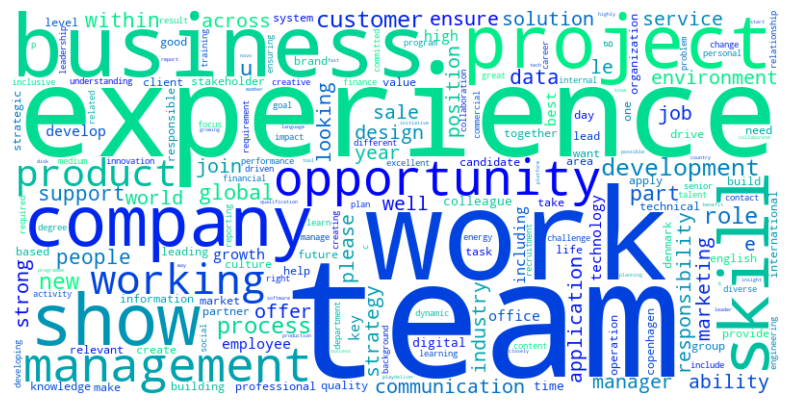

In [15]:
all_text = ' '.join(corpus)

wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white', 
                      colormap = 'winter', 
                      collocations=False).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Top words in the corpus

In [16]:
import pandas as pd

df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
word_importance = df_tfidf.mean().sort_values(ascending=False)

The top 5 words in the corpus, and also the least 5 important words:

In [17]:
word_importance

team            0.049968
work            0.038458
experience      0.036785
project         0.035757
business        0.032952
                  ...   
solicit         0.000019
davos           0.000019
fundraiser      0.000019
multilateral    0.000019
proving         0.000019
Length: 10477, dtype: float64

A quick visualisation of the top 20 words in the job market, together with their TF-IDF scores:

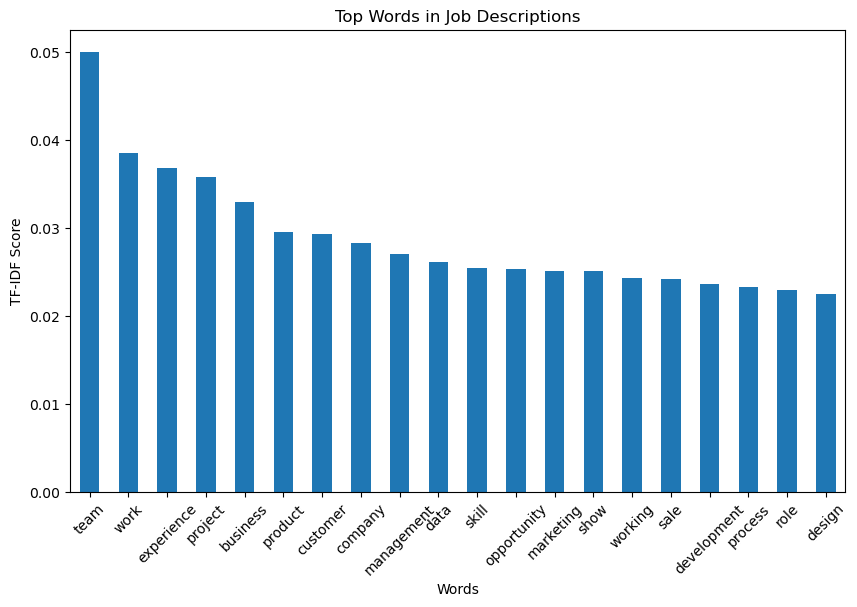

In [18]:
top_n = 20
top_words = df_tfidf.mean().nlargest(top_n)

plt.figure(figsize=(10, 6))
top_words.plot(kind='bar')
plt.title('Top Words in Job Descriptions')
plt.ylabel('TF-IDF Score')
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.show()

# Graph

## Creating the graph

* While building the graph, we considered each node as a job post. The node name is the index in the dataset, and the attributes are: the industry, the company, the location and the job description itself.
* We took top 20 words with respect to their TF-IDF scores. If two job posters had at least 5 common words in this top, then we considered that they are similar, and we draw an edge.

In [64]:
IS_GRAPH = False

if IS_GRAPH:
    G = nx.read_gml('companies_graph_2.gml')
else:
    G = nx.Graph()
    for elem in tqdm(all_tf_idfs.items()):
        row = df.iloc[elem[0]]
        jd = row['description']
        company = row['company']
        industry = row['industries']
        location = row['location']
        top_words = [w[0] for w in elem[1]][:15]
        G.add_node(elem[0], industry = industry, company = company, location = location, job_desc = jd)
        for elem_aux in all_tf_idfs.items():
            if elem_aux[0] == elem[0]:
                continue
            top_words_aux = [w[0] for w in elem_aux[1]][:15]
            common_words = [word for word in top_words_aux if word in top_words]
            if len(common_words) >= 5:
                G.add_edge(elem_aux[0], elem[0])
        nx.write_gml(G, 'companies_graph_2.gml')

100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [04:12<00:00,  3.51it/s]


## Graph analysis

In [65]:
l = [node for node in G.nodes() if G.degree(node) == 0]
for node in l:
    G.remove_node(node)

In [66]:
print('Number of nodes: {}'.format(len(G.nodes())))
print('Number of edges: {}'.format(len(G.edges())))

Number of nodes: 727
Number of edges: 3202


Eliminating the self-loops. It will be useful when we analyse the graph communities, so that no self-loop shall count as a community itself.

In [67]:
self_loops = [edge for edge in G.edges() if edge[0] == edge[1]]
print('# of self-loops: {}'.format(len(self_loops)))
for edge in self_loops:
    G.remove_edge(*edge)

# of self-loops: 0


Creating a color map for the industires: each industry is assigned to a color

In [68]:
industries = list(set(nx.get_node_attributes(G, 'industry').values()))

color_state_map = dict(zip(industries, range(len(industries))))
node_color = [color_state_map[node[1]['industry']] for node in G.nodes(data=True)]
jet = cm = plt.get_cmap('tab20c')
cNorm  = colors.Normalize(vmin=0, vmax=max(node_color))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

Analysing how many jobs are in each industry. As expected, most jobs are in the IT, Financial and the Manufacturing industries

In [69]:
for industry in industries:
    print('{0}: {1} nodes'.format(industry, len([node for node in G.nodes() if G.nodes[node]['industry'] == industry])))

Transportation and Logistics: 25 nodes
Technology and Information: 170 nodes
Education and Non-profit: 5 nodes
Manufacturing: 159 nodes
Services and Miscellaneous: 87 nodes
Food and Beverage: 21 nodes
Real Estate and Construction: 16 nodes
Retail and Consumer Goods: 25 nodes
Aerospace and Defense: 9 nodes
Healthcare and Pharmaceuticals: 38 nodes
Financial: 133 nodes
Energy and Environment: 39 nodes


Getting the number of edges that connect jobs from different industries. One of our goals in this research is to observe which industries are connected the most. When we counted the edges, we considered that edge (a,b) is the same with (b,a).

In [70]:
from collections import Counter

dif_edges = [(G.nodes[edge[0]]['industry'], G.nodes[edge[1]]['industry']) for edge in G.edges() if G.nodes[edge[0]]['industry'] != G.nodes[edge[1]]['industry']]
print('No. of edges, different industries: {}'.format(len(dif_edges)))
tuple_counter = Counter(map(frozenset, dif_edges))
tuple_counter = sorted([(tuple(unique_tuple), count) for unique_tuple, count in tuple_counter.items()], key = lambda x: x[1], reverse = True)

No. of edges, different industries: 817


Top 5 connected industries

In [71]:
tuple_counter[:5]

[(('Technology and Information', 'Financial'), 113),
 (('Manufacturing', 'Financial'), 86),
 (('Technology and Information', 'Manufacturing'), 67),
 (('Services and Miscellaneous', 'Manufacturing'), 53),
 (('Services and Miscellaneous', 'Technology and Information'), 47)]

Least connected industries

In [72]:
tuple_counter[-5:]

[(('Services and Miscellaneous', 'Education and Non-profit'), 1),
 (('Education and Non-profit', 'Manufacturing'), 1),
 (('Food and Beverage', 'Energy and Environment'), 1),
 (('Services and Miscellaneous', 'Real Estate and Construction'), 1),
 (('Retail and Consumer Goods', 'Education and Non-profit'), 1)]

## Visualise the graph

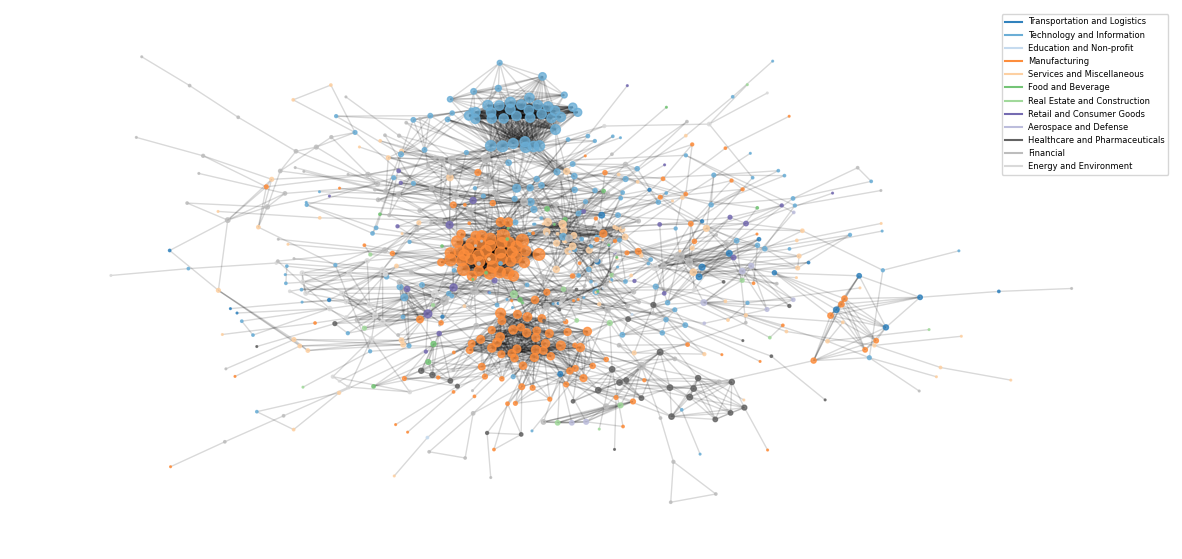

In [73]:
pos = nx.kamada_kawai_layout(G)

node_size = [1.5 * G.degree(node) for node in G.nodes()]

f = plt.figure(figsize=(15,7))
ax = f.add_subplot(1,1,1)
for label in color_state_map:
    ax.plot([0],[0],color=scalarMap.to_rgba(color_state_map[label]),label=label)
nx.draw_networkx_nodes(G, 
                       pos, 
                       node_size = node_size, 
                       cmap = jet, 
                       vmin=0, 
                       vmax= max(node_color),
                       node_color=node_color,
                       ax=ax,
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.15)
plt.axis('off')
# f.set_facecolor('w')
plt.legend(loc = 1, prop={'size': 6})
# f.tight_layout()
plt.show()

## Degree distribution

Computing the node degrees distribution

In [75]:
degrees = {node: G.degree(node) for node in G.nodes()}

In [76]:
bins = [i for i in range(min(list(degrees.values())), max(list(degrees.values())) + 1)]
degrees_hist, degrees_bin = np.histogram(list(degrees.values()), bins=bins)

Displaying the distribution in a log-log plot. It is easier to observe the hubs this way, and that the degree distribution follows a power law.

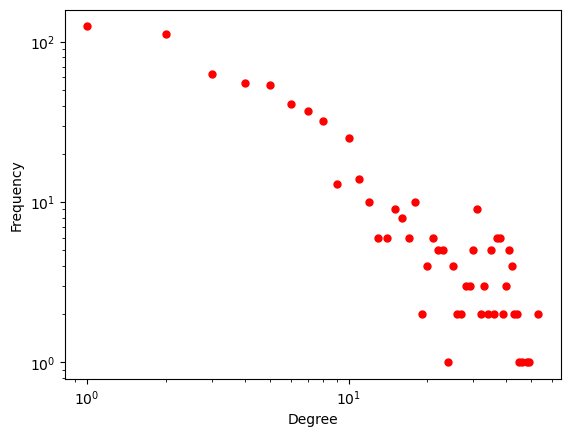

In [77]:
plt.loglog(degrees_bin[:-1], degrees_hist, 'ro', markersize=5)
plt.xlabel('Degree')
plt.ylabel('Frequency')
# plt.title('Degree distribution - logarithmic scale')
plt.show()

The histogram of the degree distribution. It is again observed how the distribution follows a power-law.

Text(0.5, 1.0, 'Degree distribution')

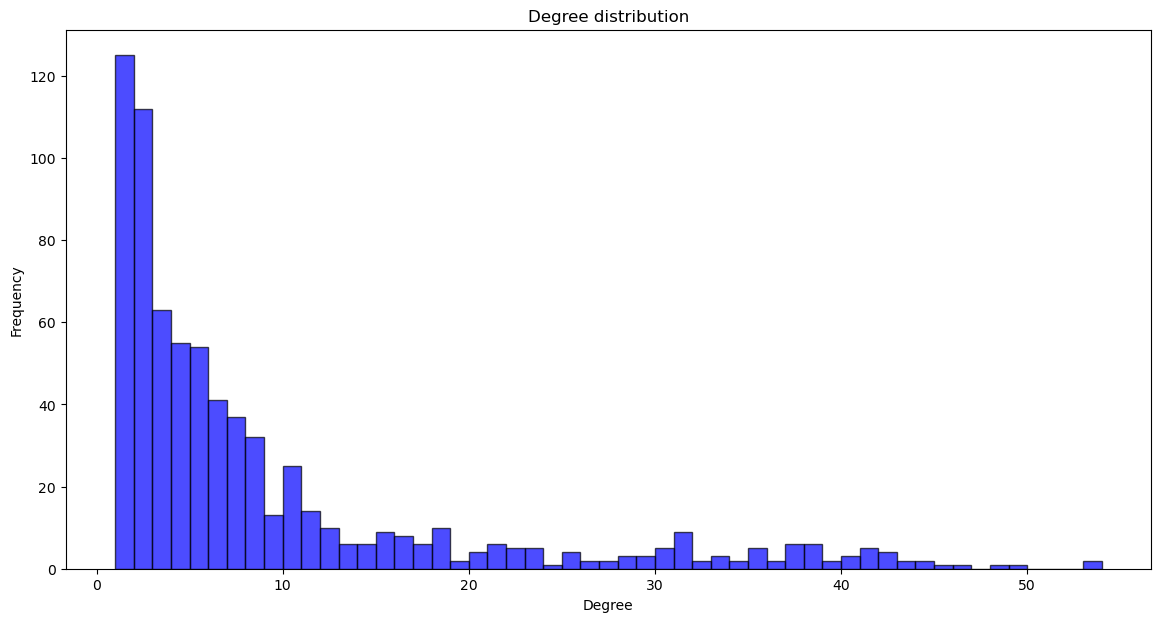

In [80]:
plt.figure(figsize=(14, 7)) 
plt.hist(list(degrees.values()), bins=range(min(list(degrees.values())), max(list(degrees.values())) + 1), alpha=0.7, width=1.0, 
         color='b', edgecolor='black', label = 'Random network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution')

Since we already identified some communities in our graph, created by the high degree nodes in the Manufacturing industry, we want to inspect the top 30 nodes with respect to their degree. 28 of them were job from the LEGO company, all in the mentioned industry, concluding that these are the nodes that form the community

In [106]:
tmp = sorted(degrees.items(), key = lambda x: x[1], reverse = True)
print('Top 30 jobs:')
print('Company'.ljust(20), 'Industry'.ljust(30), 'Degree')
print(60 * '-')
for item in tmp[:30]:
    print(G.nodes[item[0]]['company'].ljust(20),G.nodes[item[0]]['industry'].ljust(30), item[1])

Top 30 jobs:
Company              Industry                       Degree
------------------------------------------------------------
the LEGO Group       Manufacturing                  54
the LEGO Group       Manufacturing                  53
the LEGO Group       Manufacturing                  49
the LEGO Group       Manufacturing                  48
the LEGO Group       Manufacturing                  46
the LEGO Group       Manufacturing                  45
the LEGO Group       Manufacturing                  44
the LEGO Group       Manufacturing                  44
the LEGO Group       Manufacturing                  43
the LEGO Group       Manufacturing                  43
the LEGO Group       Manufacturing                  42
the LEGO Group       Manufacturing                  42
the LEGO Group       Manufacturing                  42
the LEGO Group       Manufacturing                  42
the LEGO Group       Manufacturing                  41
the LEGO Group       Manufacturing        

Top 5 companies regarding their number of jobs. LEGO is the 3rd one. Novo Nordisk is also one of the biggest Danish company, so it is normal to see this many jobs offered by them. The other 3 are recruitment social platforms, which use LinkedIn to facilitate the job search process

In [157]:
companies = [G.nodes[node]['company'] for node in G.nodes()]
comp_freq = [(comp, companies.count(comp)) for comp in list(set(companies))]
comp_freq = sorted(comp_freq, key = lambda x: x[1], reverse = True)
comp_freq[:5]

[('The Hub', 48),
 ('Novo Nordisk', 48),
 ('the LEGO Group', 43),
 ('GatedTalent - Connecting Top Executive Search Firms And Executives ', 23),
 ('HRtechX', 20)]

Calclating the exponent of the power-law distribution. Since its value is in $[2,3]$, the network can be considered a scale-free network with the ultra small property: $\langle d \rangle \sim ln(ln(N))$, where $<d>$ is the average shortest path in the graph, and $N$ is the number of nodes.

In [83]:
import powerlaw

exponent = powerlaw.Fit(list(degrees.values())).alpha
print('Degree exponent: %.2f' % exponent)
# out_degree_exponent = powerlaw.Fit(out_degrees, verbose = False).alpha

Degree exponent: 2.18


Calculating best minimal value for power law fit
C:\ProgramData\anaconda3\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


## Clustering coefficient

High clustering coefficient: if a job node is connected to two other job postings, there's a higher possibility that those two are also connected to each other. This is beneficial for job seekers or recruiters

In [84]:
#random graph for comparison
random_graph = nx.erdos_renyi_graph(n=len(G.nodes()), p=0.015)

print("Original Graph: Average Clustering Coefficient:", nx.average_clustering(G))
print("Random Graph: Average Clustering Coefficient:", nx.average_clustering(random_graph))

Original Graph: Average Clustering Coefficient: 0.4570091705642717
Random Graph: Average Clustering Coefficient: 0.012303868461856889


## Community analysis

We used the Louvain algorithm to determine the number of communities. We determine the optimal resolution in an effort to maximize the graph modularity.

In [85]:
resolution_range = np.arange(0.5, 3, 0.1)
best_modularity = -100
optimal_resolution = 0

for res in resolution_range:
    communities = nx.community.louvain_communities(G, resolution=res, seed=42)
    modularity = nx.community.modularity(G, communities)
    if modularity > best_modularity:
        best_modularity = modularity
        optimal_resolution = res

print("Optimal resolution: %.2f" % optimal_resolution)
print("Best modularity: %.2f" % best_modularity)
print(f'communities: {len(communities)}')


Optimal resolution: 1.30
Best modularity: 0.76
communities: 70


In [86]:
communities = nx.community.louvain_communities(G, resolution=optimal_resolution, seed=42)

In [158]:
c = 0
for com in communities:
    tmp_ = []
    for node in com:
        tmp_.append(G.nodes[node]['industry'])
    if tmp_.count(tmp_[0]) == len(tmp_):
        c += 1

print(f'Communities with nodes from the same industry: {c}')

Communities with nodes from the same industry: 28


Determining the community with most nodes

In [159]:
highest_comm = sorted(communities, key = len)[-1]
print(f'Number of nodes: {len(highest_comm)}')

Number of nodes: 95


Determinig the number of jobs per industry in the community. We wanted to check if there is a majority of jobs in a certain industry, but the distribution seems to be similar to the one of the entire network.

In [89]:
ind_ = [G.nodes[node]['industry'] for node in highest_comm]
for i in set(ind_):
    print(i, '...', ind_.count(i))

Transportation and Logistics ... 5
Technology and Information ... 23
Manufacturing ... 13
Services and Miscellaneous ... 23
Real Estate and Construction ... 3
Food and Beverage ... 1
Retail and Consumer Goods ... 9
Aerospace and Defense ... 5
Healthcare and Pharmaceuticals ... 4
Financial ... 7
Energy and Environment ... 2


Comparing the results with two other cases: We considered each industry as a community, and we calculated the modularity of this partitioning.

In [90]:
from collections import defaultdict

industry_sets = defaultdict(set)
for node, data in G.nodes(data=True):
    industry = data.get('industry') 
    if industry is not None:
        industry_sets[industry].add(node)

industry_node_sets = list(industry_sets.values())

In [91]:
modularity = nx.community.modularity(G, industry_node_sets)
print("Modularity for industry-based communities: %.2f" % modularity)

Modularity for industry-based communities: 0.47


In the other case, we considered each location as a commumnity, but we finally decided not to include it in the report, since it's not that relevant.

In [92]:
location_sets = defaultdict(set)

for node, data in G.nodes(data=True):
    location = data.get('location') 
    if location is not None:
        location_sets[location].add(node)

location_node_sets = list(location_sets.values())

In [93]:
modularity_location = nx.community.modularity(G, location_node_sets)
print("Modularity for location-based communities:", modularity_location)

Modularity for location-based communities: 0.2795099760026623


# Sentiment analysis

### Converting the LabMT text file to a Pandas dataframe
> * Based on the LabMT word list, the avg_sentiment_calculator function calculates sentiment given a list of job description tokens
> * The iteration over the job descriptions in our dataset, we tokenize each page, and calculate sentiment every single description.

In [94]:
df_labmt = pd.DataFrame(columns = ['word', 'happiness_rank', 'happiness_average', 'happiness_standard_deviation', 
                                  'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank'])

In [95]:
f = open("data/datasets/sentiment_data.txt", "r")
for i, x in enumerate(f):
    if i < 4:
        continue
    
    df_labmt.loc[len(df_labmt)] = re.findall(r'\S+', x)
    

wordlist = dict(zip(list(df_labmt['word']), [float(item) for item in df_labmt['happiness_average']]))

In [96]:
df_labmt.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


### Average sentiment of a given tokens list

In [97]:
def avg_sentiment_calulator(tokens, wordlist):
    if len(tokens) == 0:
        raise Exception("Empty list of tokens.")
    freq_dict = dict(FreqDist(tokens))
    valid_tokens = [token for token in tokens if token in list(wordlist.keys())]
    avg_sent = sum(freq_dict[token]*wordlist[token] for token in valid_tokens)/sum(freq_dict[token] for token in valid_tokens)
    return avg_sent

We included the sentiment of each job description in the final dataset as the `sentiment` column.

In [144]:
from nltk.probability import FreqDist

sentiment_list = []
sentiments = {}
for corp in corpus:
    tokens = word_tokenize(corp)
    if len(tokens) == 0:
        continue
    tokens = [token.lower() for token in tokens]
    avg_sent = avg_sentiment_calulator(tokens, wordlist)
    sentiment_list.append(round(avg_sent, 2)) 
df['sentiment'] = sentiment_list

In [99]:
sentiment_scores = list(sentiment_list)
bins = np.arange(min(sentiment_scores), max(sentiment_scores) + 0.05, 0.05)

### Sentiment scores histogram
> * Create a histogram of all job description's associated page-sentiments and calculate the mean, median 10th and 90th percentage of the descriptions.

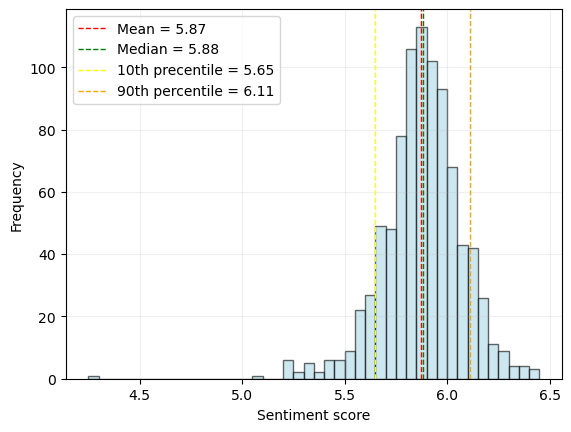

In [160]:
bins = np.arange(min(sentiment_list), max(sentiment_list) + 0.05, 0.05)
plt.hist(sentiment_list, bins=bins, alpha=0.6, color='lightblue', edgecolor='black')
mean = np.mean(sentiment_list)
median = np.median(sentiment_list)
p_10 = np.percentile(sentiment_list, 10)
p_90 = np.percentile(sentiment_list, 90)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean = {mean:.2f}')
plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label=f'Median = {median:.2f}')
plt.axvline(p_10, color='yellow', linestyle='dashed', linewidth=1, label=f'10th precentile = {p_10:.2f}')
plt.axvline(p_90, color='orange', linestyle='dashed', linewidth=1, label=f'90th percentile = {p_90:.2f}')
# plt.title("Histogram - job description  sentiment")
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

In the report, we did not include the percentiles, since they did not deliver as much information as the mean or median.

### The 'happiest' company

In [109]:
df.loc[df['sentiment'] == max(df['sentiment'])]

,id,company,title,location,num_applicants,date_posted,experience,employment_type,industries,description,sentiment
831,3763553557,the LEGO Group,learning design manager specialist,South Denmark,27 applicants,2023-11-15,Mid-Senior level,Full-time,Manufacturing,job descriptionare you ready to redefine learn...,6.44


We determined the top 10 happiest words and their frequency, as well as their position, in the job description. A visualisation of this was made using a lexical dispertion plot.

['learning', 'design', 'play', 'child', 'lego', 'experience', 'team', 'digital', 'skill', 'face']


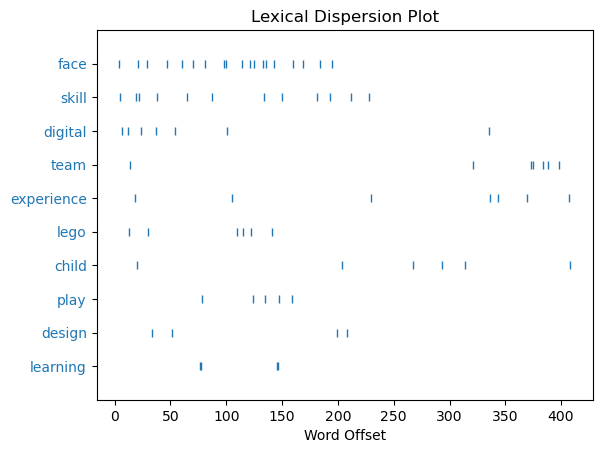

In [112]:
import nltk
from operator import itemgetter 

max_corp = corpus[831]
tokens = word_tokenize(max_corp)
tokens = [token.lower() for token in tokens]
freq_dict = dict(FreqDist(tokens))
valid_tokens = [token for token in tokens if token in list(wordlist.keys())]
happy_words = [freq_dict[token] for token in valid_tokens]
happy_scores = [freq_dict[token]*wordlist[token] for token in valid_tokens]

res = {valid_tokens[i]: happy_scores[i] for i in range(len(valid_tokens))}

# Initialize K 
K = 10

# Smallest K values in Dictionary 
# Using sorted() + itemgetter() + items() 

happiest_words = sorted(res, key=res.get, reverse=True)[:10]
print(happiest_words)

tokens = nltk.word_tokenize(corpus[831])
text = nltk.Text(tokens)
text.dispersion_plot(happiest_words)

### The 'saddest' company

In [119]:
df.loc[df['sentiment'] == min(df['sentiment'])]

,id,company,title,location,num_applicants,date_posted,experience,employment_type,industries,description,sentiment
765,3716914342,Paymentology,global head of fraud,Capital Region,30 applicants,2023-11-15,Mid-Senior level,Full-time,Financial,paymentology is the first truly global issuer-...,4.25


In [120]:
from operator import itemgetter 
min_corp = corpus[765]
tokens = word_tokenize(min_corp)
tokens = [token.lower() for token in tokens]
freq_dict = dict(FreqDist(tokens))
valid_tokens = [token for token in tokens if token in list(wordlist.keys())]
sad_words = [freq_dict[token] for token in valid_tokens]
sad_scores = [freq_dict[token]*wordlist[token] for token in valid_tokens]

res = {valid_tokens[i]: sad_scores[i] for i in range(len(valid_tokens))}
# Initialize K 
K = 12
# Smallest K values in Dictionary 
# Using sorted() + itemgetter() + items() 
saddest_words = dict(sorted(res.items(), key = itemgetter(1))[:K]) 
#print(saddest_words.keys())

In [122]:
saddest_words

{'suspicious': 3.28,
 'apart': 3.52,
 'deadline': 3.66,
 'least': 4.0,
 'incident': 4.02,
 'enforcement': 4.1,
 'intervention': 4.26,
 'issue': 4.48,
 'c': 4.7,
 'assume': 4.72,
 'e': 4.72,
 'operate': 4.74}

The exact same thing was done for the "saddest" job description

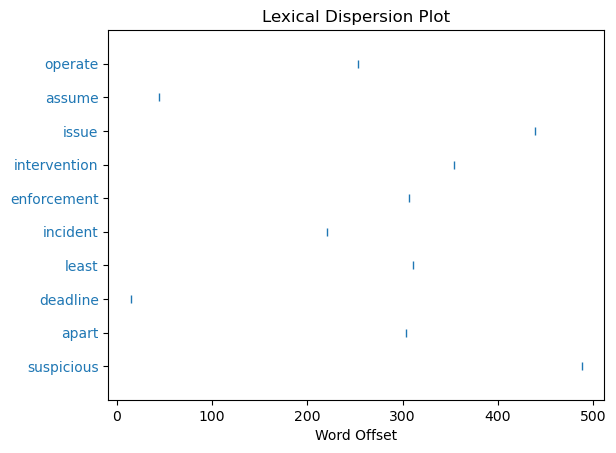

In [121]:
#print(corpus[839])
#print(saddest_words)
my_sad_words = ['suspicious', 'apart', 'deadline', 'least', 'incident', 'enforcement', 'intervention', 'issue', 'assume', 'operate']
tokens = nltk.word_tokenize(corpus[765])
text = nltk.Text(tokens)
#print(text)
#text.dispersion_plot(saddest_words.keys())
text.dispersion_plot(my_sad_words)

### Sentiment sum

Top 5 happiest companies and top 5 saddest companies. It seems that the saddes companies tend to belong to the pharmaceutical industry, but we did not include this information in our report, since we had few job descriptions for these companies.

In [145]:
df.groupby(['company'])['sentiment'].mean().sort_values()

company
Paymentology                 4.250
Minapharm Pharmaceuticals    5.210
LEO Pharma                   5.240
SilverBack                   5.310
FACTOR 7                     5.310
                             ...  
Superb                       6.230
The LEGO Foundation          6.300
Nature Energy                6.365
Gasoline Grill               6.370
Skillsearch                  6.380
Name: sentiment, Length: 367, dtype: float64

Determining the average sentiment of each industry. The sentiment score tends to stay in a narrow range, so the industry does not have a high impact on the jobs' sentiment scores

In [151]:
df_industry_group_mean = df.groupby(['industries'])['sentiment'].mean()
df_industry_group_count = df.groupby(['industries'])[ 'company'].count()
# df_industry_group_sum = df.groupby(['industries'])[ 'num_applicants'].sum()
result = pd.concat([df_industry_group_count, df_industry_group_mean], axis = 1)  
# result.drop(columns=['id'], inplace = True)
# result.rename(columns={"num_applicants": "Number of applicants", "company": "Companies", "sentiment": "Average sentiment score"})

In [152]:
result

,company,sentiment
industries,,
Aerospace and Defense,9,5.880000
Education and Non-profit,13,5.849231
Energy and Environment,41,5.850244
Financial,176,5.859489
Food and Beverage,26,5.952308
Healthcare and Pharmaceuticals,45,5.822000
Manufacturing,174,5.902529
Real Estate and Construction,22,5.815909
Retail and Consumer Goods,35,5.894571
